In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython import display
from tensorflow.keras import layers, datasets
import os
import imageio
import shutil
import time
import PIL
from keras.initializers import RandomNormal
import random



Using TensorFlow backend.


In [0]:
# Define a function to make data usable by a NN and another one to make the generated images in type to be plot
def preprocess(x, size, channels=1):    
    """ Define a function to make data usable by a NN """
    
    x = x.reshape(-1, size, size, channels) 
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    
    tx = tf.data.Dataset.from_tensor_slices(x)
    return tx

def deprocess(x, size, channels): 
    """ Define a function to make the generated images usable by imshow """
    
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    if channels == 1:
      x = x.reshape(size, size)
    else:
      x = x.reshape(size, size, channels)
    return x


def make_trainable(model, trainable):
    """ To make trainable or not trainable the parameter of the a NN """
    
    for layer in model.layers:
        layer.trainable = trainable

def maxlikeloss(y_true, y_pred):
    def inverse_sigmoid(y):
      return tf.math.log(y/(1-y))
    lss = -0.5*tf.math.exp(inverse_sigmoid(y_pred))
    return lss

In [0]:
class GAN():
    
    def __init__(self, name, data):
        
        # These are just default values, it is always better to call the proper function to
        # initialize them
        
        self.name = name
        self.data = data
        self.val_frac = 0.01

        self.game = "non_saturating"
        
        self.size = 32
        self.channels = 3
        self.batch_size = 128
        self.noise_dim = 100
        
        self.d_learning_rate = 0.001
        self.g_learning_rate = 0.0001
        self.d_beta1 = 0.9
        self.g_beta1 = 0.9
        self.leaky_alpha = 0.2
        
        self.epochs = 10
        self.model_complexity = 7
        self.samples_to_generate = 16
        self.training_time = 0
        self.seed = tf.random.normal([self.samples_to_generate, self.noise_dim])

        self.losses = {"Train": {'Gen': [], 'Disc': []}, "Test": {'Gen': [], 'Disc': []}}
        
        self.networks = {"Generator": None, "Discriminator": None}

        # new working directory
        self.main_folder = 'GAN_' + str(self.name) + '/'
        if os.path.exists(self.main_folder):
          shutil.rmtree(self.main_folder)
          os.mkdir(self.main_folder)
        else:
          os.mkdir(self.main_folder)


    def set_training_parameters(self, epochs=50, batch_size=128, d_lr=0.001, g_lr=0.0001, d_beta=0.9, g_beta=0.9, alpha=0.2, vf=0.01,
                                size=32, ch=3, noise=100, smpls=16, mdl_cmplx=7, game="non_saturating"):

        self.batch_size = batch_size
        self.d_learning_rate = d_lr
        self.g_learning_rate = g_lr
        self.d_beta1 = d_beta
        self.g_beta1 = g_beta
        self.leaky_alpha = alpha
        self.epochs = epochs
        self.size = size
        self.channels = ch
        self.val_frac = vf
        self.noise_dim = noise
        self.samples_to_generate = smpls
        self.model_complexity = mdl_cmplx
        self.seed = tf.random.normal([smpls, noise])
        self.game=game


    
    def build_generator(self, summary=False):

        s = self.size//8
        mc = self.model_complexity 

        model = tf.keras.Sequential(name = "Generator")

        model.add(layers.Dense(s*s*2**(mc+2), use_bias=False, input_shape=(self.noise_dim,)))
        model.add(layers.Reshape(target_shape=(s, s, 2**(mc+2))))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(self.leaky_alpha))
        
        model.add(layers.Conv2DTranspose(2**(mc+1), kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.2)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(self.leaky_alpha))

        model.add(layers.Conv2DTranspose(2**mc, kernel_size=4, strides=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.2)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(self.leaky_alpha))
        
        model.add(layers.Conv2DTranspose(self.channels, kernel_size=4, strides=2, padding='same', activation='tanh', kernel_initializer=RandomNormal(stddev=0.2)))      
        
        
        self.networks["Generator"] = model
        
        if summary: print(model.summary())
        
        return model
    
    
    def build_discriminator(self, summary=False):
        
        mc = self.model_complexity

        model = tf.keras.Sequential(name = "Discriminator")
        
        model.add(layers.Conv2D(2**(mc-1), kernel_size=4, strides=1, padding='same', input_shape=(self.size, self.size, self.channels)))
        model.add(layers.LeakyReLU(self.leaky_alpha))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Conv2D(2**mc, kernel_size=4, strides=2, padding='same'))  
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(self.leaky_alpha))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(2**(mc+1), kernel_size=4, strides=2, padding='same'))  
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(self.leaky_alpha))
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))


        self.networks["Discriminator"] = model
        
        if summary: print(model.summary())
        
        return model

    
    def Train(self, progress=False):

        test_size = int(self.val_frac*len(self.data))
        error_seed = self.make_latent_samples(test_size)
        
        x_train, x_test = train_test_split(self.data, test_size=self.val_frac)
        
        x_train_real = preprocess(x_train, self.size, self.channels)
        x_test_real  = preprocess(x_test, self.size, self.channels)

        x_train_real = x_train_real.batch(self.batch_size, drop_remainder=True)
     
        y_train_real = tf.ones([self.batch_size, 1])
        y_train_fake = tf.zeros([self.batch_size, 1])
        y_eval_real  = tf.ones([test_size, 1])
        y_eval_fake  = tf.zeros([test_size, 1])
        
        # Generator
        generator = self.build_generator()

        # Discriminator
        discriminator = self.build_discriminator()
        if self.game in ["minimax", "non_saturating", "max_likelihood"]:
          discriminator.compile(optimizer=Adam(lr=self.d_learning_rate, beta_1=self.d_beta1), loss='binary_crossentropy')
        if self.game=="least_squares":
          discriminator.compile(optimizer=Adam(lr=self.d_learning_rate, beta_1=self.d_beta1), loss='mse')
        
        
        # GAN
        gan = tf.keras.Sequential([generator, discriminator])
        if self.game in ["minimax", "non_saturating"]:
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss='binary_crossentropy')
        if self.game=="least_squares":
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss='mse')
        if self.game=="max_likelihood":
          gan.compile(optimizer=Adam(lr=self.g_learning_rate, beta_1=self.g_beta1), loss=maxlikeloss)
        
    
        start = time.time()

        for epoch in tqdm(range(self.epochs)):

          # Shuffeling data each epoch
            x_train_real = x_train_real.shuffle(len(x_train), reshuffle_each_iteration=False) 
            x_test_real  = x_test_real.shuffle(len(x_test), reshuffle_each_iteration=False)

            for x_batch_real in x_train_real:
                
                # latent samples and the generated digit images
                latent_samples = self.make_latent_samples(n=self.batch_size)
                x_batch_fake = generator.predict_on_batch(latent_samples)
                
                # train the discriminator to detect real and fake images
                make_trainable(discriminator, True)
                d_loss_real = discriminator.train_on_batch(x_batch_real, y_train_real * random.uniform(0.9, 1.0))
                d_loss_fake = discriminator.train_on_batch(x_batch_fake, y_train_fake)
                
                # train the generator via GAN
                make_trainable(discriminator, False)
                if self.game=="minimax":
                  g_loss = gan.train_on_batch(latent_samples, y_train_fake)
                if self.game in ["non_saturating", "least_squares", "max_likelihood"]:
                  g_loss = gan.train_on_batch(latent_samples, y_train_real)
                
                
                self.losses["Train"]["Disc"].append(0.5*np.add(d_loss_real, d_loss_fake))
                self.losses["Train"]["Gen"].append(g_loss)
                

            # evaluate
            x_eval_real = list(x_test_real.as_numpy_iterator())
            x_eval_real = np.array(x_eval_real)[np.random.choice(len(x_test), test_size, replace=False)]

            x_eval_fake_plot = generator.predict_on_batch(self.seed)
            x_eval_fake = generator.predict_on_batch(error_seed)
            
            d_loss  = discriminator.test_on_batch(x_eval_real, y_eval_real)*0.5
            d_loss += discriminator.test_on_batch(x_eval_fake, y_eval_fake)*0.5 

            
            if self.game=="minimax":
              g_loss  = gan.test_on_batch(error_seed, y_eval_fake) 
            if self.game in ["non_saturating", "least_squares", "max_likelihood"]:
              g_loss  = gan.test_on_batch(error_seed, y_eval_real) 

                      
                
            self.losses["Test"]["Disc"].append(d_loss)
            self.losses["Test"]["Gen"].append(g_loss)

            
            display.clear_output(wait=True)    
            if progress:
                print("Epoch:{:>3}/{},   Discriminator Loss:{:>7.4f},     Generator Loss:{:>7.4f}".format(epoch+1, self.epochs, d_loss, g_loss))
                self.show_progress(x_eval_fake_plot, epoch)

        self.training_time = time.time() - start
        print('\nTotal training time: ', self.training_time)
            

            
    
    def show_progress(self, generated_images, epoch):

        if os.path.exists(self.main_folder + 'progress_images/'):
          pass
        else: os.mkdir(self.main_folder + 'progress_images/')

        fig = plt.figure(figsize=(10,10))
        fig.suptitle('Epoch:{:4d}'.format(epoch+1), fontsize=15)
        s = len(generated_images)

        rows = 4
        cols = 4

        for i in range(s):
            img = deprocess(generated_images[i], self.size, self.channels)
            plt.subplot(rows, cols, i+1)
            if self.channels == 1:
              plt.imshow(img, cmap='gray')
            else:
              plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(self.main_folder + 'progress_images/image_at_epoch_{:04d}.png'.format(epoch+1))
        plt.show()
        
        return
    
    
    def Plot_losses(self, step="Test"):
        losses = np.array([self.losses[step]["Disc"], self.losses[step]["Gen"]])    
    
        fig, ax = plt.subplots()
        plt.plot(losses[0], label='Discriminator', color='blue')
        plt.plot(losses[1], label='Generator', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(step + " Losses")
        ax.set_ylim(bottom=0)
        plt.legend()
        plt.show()


    def Get_progress_GIF(self):
        
        im_dir = self.main_folder + '/progress_images/'
        images = []

        for file_name in sorted(os.listdir(im_dir)):
          if file_name.endswith('.png'):
            file_path = os.path.join(im_dir, file_name)
            images.append(imageio.imread(file_path))
        
        imageio.mimsave(self.main_folder + 'GAN.gif', images, fps=5)


    def Get_Model(self, key):
        return self.networks[key]
    
    def Save_parameters(self):
        with open(self.main_folder + 'parameters.txt', 'w') as file:
          file.write('Generative Adversarial Network: {}\n'.format(self.name))
          file.write('\n')
          file.write('Data shape: {}\n'.format(self.data.shape))
          file.write('Validation fraction: {}\n'.format(self.val_frac))
          file.write('Dimension of the latent data: {}\n'.format(self.noise_dim))

          file.write('\n' + '----- Discriminator -----\n')
          file.write('Learning rate of the discriminator: {}\n'.format(self.d_learning_rate))
          file.write('Beta parameter of the discriminator: {}\n'.format(self.d_beta1))
          self.networks['Discriminator'].summary(print_fn=lambda x: file.write(x + '\n'))

          file.write('\n' + '----- Generator -----\n')
          file.write('Learning rate of the generator: {}\n'.format(self.g_learning_rate))
          file.write('Beta parameter of the generator: {}\n'.format(self.g_beta1))
          self.networks['Generator'].summary(print_fn=lambda x: file.write(x + '\n'))

          file.write('\n' + '----- Training parameters -----\n')
          file.write('Number of epochs: {}\n'.format(self.epochs))
          file.write('Total training time: {}\n'.format(self.training_time))
          file.write('Model complexity: {}\n'.format(self.model_complexity))
    
    def Save_model(self, key, path):   
        target = path + "/" + key + '.h5'        
        self.networks[key].save(target)
        print(key + " successfully saved")
        return
    
    def Restore_model(self, key, path):
        self.networks[key] = tf.keras.models.load_model(path)
        print(key + " successfully restored")
        return 
    
    def make_latent_samples(self, n=1):
        noise = tf.random.normal([n, self.noise_dim])
        return noise
    
     

In [0]:
# IMPORT DATA
(X_train, _), (X_test, _) = datasets.mnist.load_data()
images = np.concatenate([X_train, X_test])

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# To unpack data, in case
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/20ksquares.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/20kcircles.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/20ktriangles.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/20kstars.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/20kredstars.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/20kshapes.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/20k4shapes.tar -C /content/
#!tar -xvf drive/My\ Drive/Colab\ Notebooks/data/celeba64.tar -C /content/

New data dimension:  (70000, 32, 32)


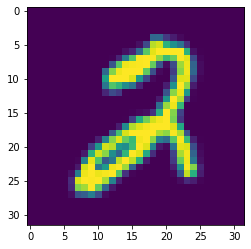

In [6]:
#images_path = '/content/pics/'
SIZE = 32

#image_names = os.listdir(images_path)
#images = np.array([imageio.imread(images_path+im) for im in image_names])
#print("Data dimension: ", images.shape)

# Scaling images 
images = np.array([np.asarray(PIL.Image.fromarray(images[i]).resize((SIZE, SIZE))) for i in range(len(images))])

# Conversion from RGBA to grayscale
#images = np.array([np.mean(images[i],axis=2) for i in range(len(images))])

# Conversion from RGBA to RGB
#images = np.array([np.asarray(PIL.Image.fromarray(images[i]).convert("RGB")) for i in range(len(images))])

print("New data dimension: ", images.shape)
plt.imshow(images[np.random.randint(len(images))])

In [0]:
DCGAN = GAN(name="MNIST", data=images)

In [0]:
# Possible games: minimax, non_saturating, least_squares, max_likelihhod

DCGAN.set_training_parameters(epochs=50, batch_size=128, d_lr=0.001, g_lr=0.0001, d_beta=0.5, g_beta=0.5, alpha=0.2, vf=0.01,
                                size=32, ch=1, noise=100, smpls=16, mdl_cmplx=6, game="non_saturating")

In [14]:
DCGAN.build_generator(summary=True)
DCGAN.build_discriminator(summary=True)

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0 

Epoch: 50/50,   Discriminator Loss: 0.3201,     Generator Loss: 3.6050


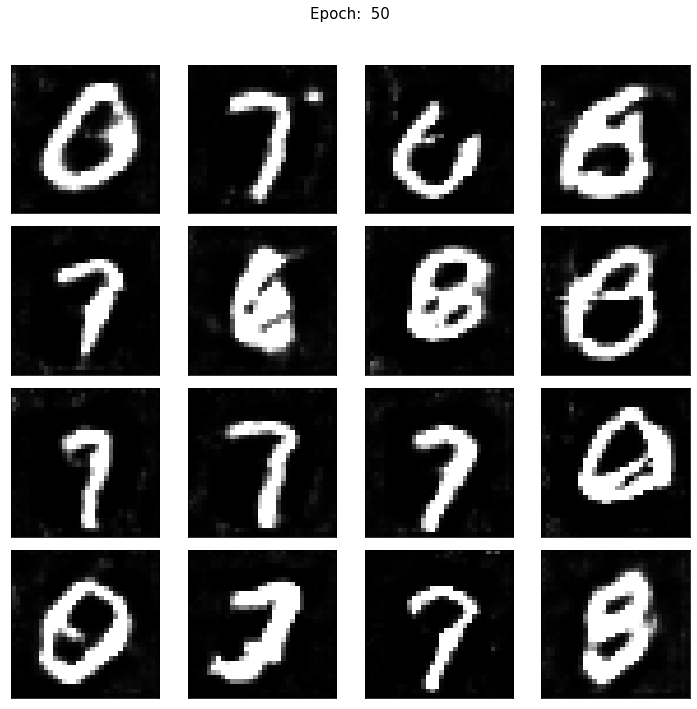


100%|██████████| 50/50 [20:34<00:00, 24.68s/it]


Total training time:  1234.1388490200043


In [15]:
DCGAN.Train(progress=True)

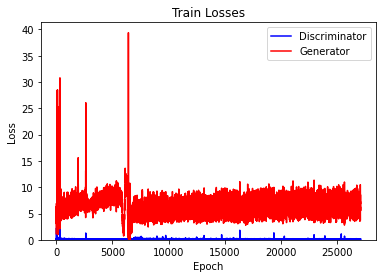

In [16]:
DCGAN.Plot_losses("Train")

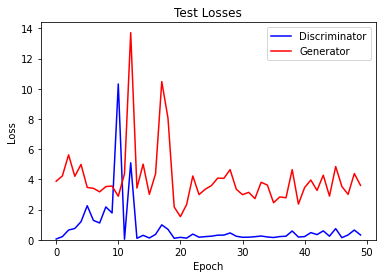

In [17]:
DCGAN.Plot_losses("Test")

In [0]:
DCGAN.Save_parameters()

In [0]:
DCGAN.Get_progress_GIF()